In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/default of credit card clients.csv")

In [4]:
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
pip install toad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 27.0 MB/s eta 0:00:00


In [7]:
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import toad
import pickle

In [8]:
data.shape

(30000, 25)

In [9]:
data['label']=data['default payment next month']
data=data.drop(columns=['default payment next month'])

In [10]:
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Proportion of fraud labels

In [11]:
#checking the fraud proportion of the data
def target_info(labels):
    fraud_count = sum(labels == 1)
    total_count = len(labels)
    fraud_proportion = fraud_count / total_count
    print(f"Fraud Proportion: {fraud_proportion:.2%}")

# Then you can call this function passing your target variable (in this case, 'label')
target_info(data['label'])


Fraud Proportion: 22.12%


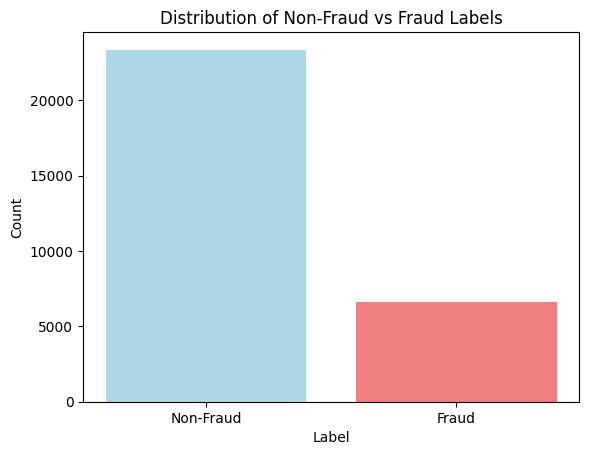

In [12]:
import matplotlib.pyplot as plt

def plot_fraud_distribution(labels):
    fraud_count = sum(labels == 1)
    non_fraud_count = sum(labels == 0)
    labels = ['Non-Fraud', 'Fraud']
    counts = [non_fraud_count, fraud_count]

    plt.bar(labels, counts, color=['lightblue', 'lightcoral'])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Non-Fraud vs Fraud Labels')
    plt.show()

# Assuming 'label' is the column containing the labels in your DataFrame df
plot_fraud_distribution(data['label'])

**Train and Test Split**

In [13]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [14]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data


In [15]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [16]:
train.label.value_counts()

0    17411
1     5088
Name: label, dtype: int64

**Feature Filtering**

In [17]:
exclude_list = ['ID','label']

In [18]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'],
                                                empty = 0.7,
                                                iv = 0.02, corr = 1,
                                                return_drop=True,
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))

keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [19]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [20]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [21]:
df_iv.shape

(22, 2)

In [22]:
df_iv.head(30)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_3,0.401513
3,PAY_4,0.349813
4,PAY_5,0.340014
5,PAY_6,0.282692
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


In [23]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning,
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

1.3990618149439493


In [24]:
combiner

In [25]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [26]:
filename

'CreditScore_save1_combiner.pkl'

In [27]:
bins = combiner.export()

In [28]:
len(bins)

21

In [29]:
bins

{'LIMIT_BAL': [50000, 60000, 80000, 110000, 150000, 230000, 370000],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501],
 'BILL_AMT2': [2400, 8287, 35213],
 'BILL_AMT3': [2400, 7458, 81890],
 'BILL_AMT4': [2501],
 'BILL_AMT5': [2395, 8110, 35288],
 'BILL_AMT6': [19195, 50442],
 'PAY_AMT1': [6, 4902],
 'PAY_AMT2': [92, 1603, 4520, 15002],
 'PAY_AMT3': [1, 2921],
 'PAY_AMT4': [1, 1506, 3946],
 'PAY_AMT5': [1, 1880, 10000],
 'PAY_AMT6': [28, 480, 926, 1078, 1501, 4060, 9567]}

In [30]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

In [31]:
train_selected_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0,1,0,4,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,1,2,2,2,2,3,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,2,1,2,2,2,2,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,2,1,2,2,2,2,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,1,1,1,2,2,2,...,1,2,0,1,4,2,3,1,2,0


In [32]:
test_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,7,1,3,2,1,2,1,2,2,...,1,3,2,2,2,2,3,2,6,0
1,22501,5,1,2,1,1,1,1,1,1,...,1,0,0,0,1,2,2,2,5,0
2,22502,6,0,2,2,1,2,2,2,2,...,1,3,1,1,2,1,2,2,5,0
3,22503,1,1,3,2,1,3,3,3,2,...,1,2,1,1,2,0,0,1,2,1
4,22504,6,1,2,2,1,2,2,2,2,...,1,3,2,2,3,2,3,2,6,1


In [33]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

21

<Axes: xlabel='PAY_AMT1', ylabel='prop'>

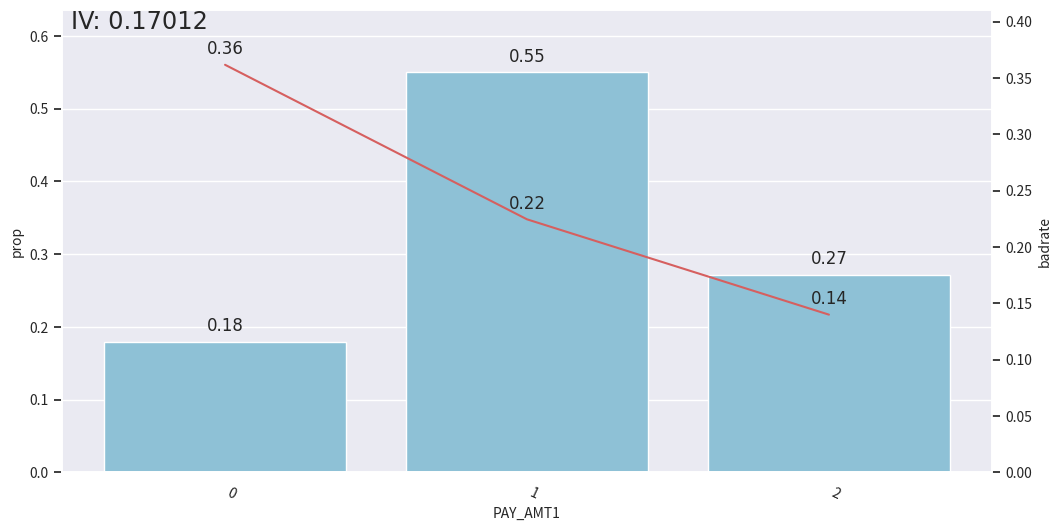

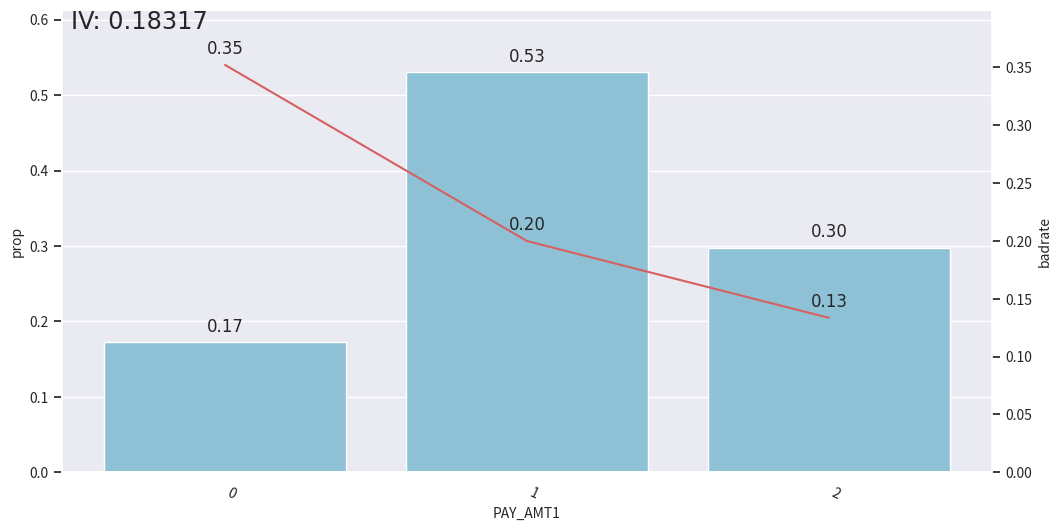

In [34]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

In [35]:
train_selected_bin.PAY_0.describe()

count    22499.000000
mean         1.988711
std          1.038531
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: PAY_0, dtype: float64

**WOE**

In [36]:
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'],
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

In [37]:
train_woe.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [38]:
final_data_woe = pd.concat([train_woe,test_woe])

In [39]:
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

Calculate PSI (Population Stability Index)

In [40]:
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})
psi_df

<ipython-input-40-ba932da87fd2>:3: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)


,feature,psi
0,EDUCATION,0.000258
1,BILL_AMT4,0.000330
2,BILL_AMT6,0.001591
3,BILL_AMT5,0.002520
4,BILL_AMT1,0.002634
5,PAY_AMT5,0.003066
6,PAY_AMT1,0.003402
7,PAY_AMT4,0.004556
8,BILL_AMT2,0.005398
9,PAY_AMT6,0.007230


In [41]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)
psi_remove

[]

In [42]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i)

In [43]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [44]:
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [45]:
print(final_data_woe.shape)

(30000, 23)


In [46]:
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

OUTPUT

In [47]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

In [48]:
df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')

In [49]:
df_iv

,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734
5,PAY_6,0.285164
6,LIMIT_BAL,0.181621
7,PAY_AMT1,0.173425
8,PAY_AMT2,0.162703
9,PAY_AMT3,0.114630


In [50]:
df_iv.to_csv('CreditScore_save4_IV.csv')

MODEL TUNING

In [51]:
def check_train_test_auc(x_train,y_train,x_test,y_test):

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)


    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))

    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))

    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
    from sklearn.metrics import RocCurveDisplay


    fig, ax = plt.subplots(figsize=(12, 8))
    lr_disp = RocCurveDisplay.from_estimator(lr, x_test, y_test,color='blue', ax=ax)
    #plot_roc_curve(lr, x_test, y_test, color='blue', ax=ax)

LOGISTIC REGRESSION

In [52]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


train KS 0.40988185783295383
train AUC 0.7703231183550197
Test KS 0.4264763906414198
Test AUC 0.7834660156584025


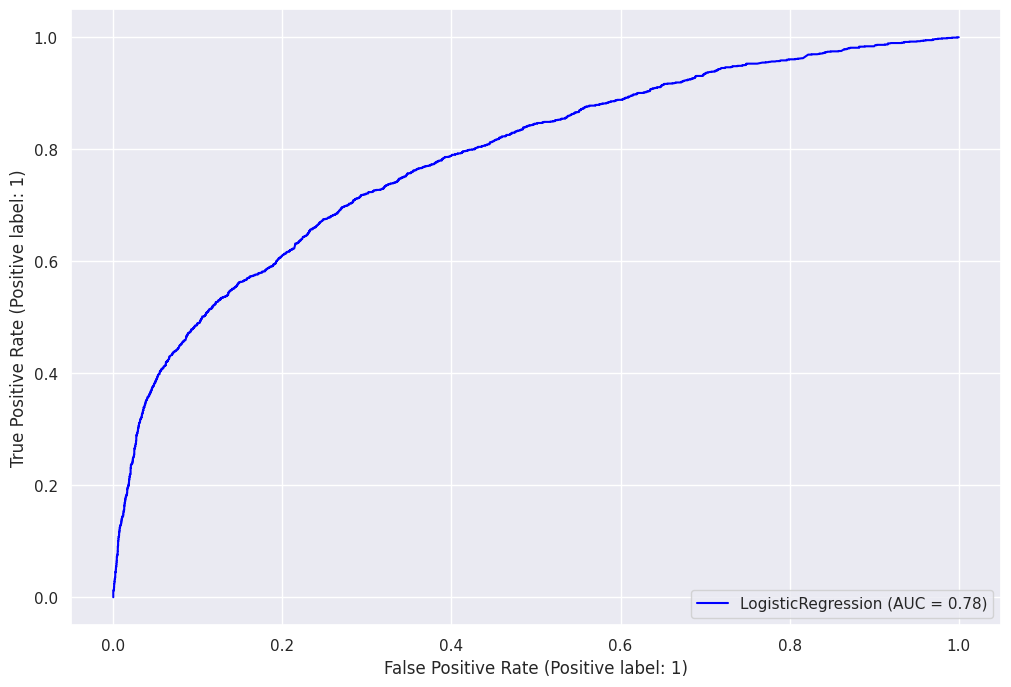

In [53]:
#train & test
#from sklearn.metrics import plot_roc_curve
check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'],
                     x_test =test_woe[features_use] ,y_test = test_woe['label'])

Accuracy: 0.8354886015197973
Precision: 0.7038961038961039
Recall: 0.35012919896640826
F1 Score: 0.46764452113891286

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.70      0.35      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.69      7501
weighted avg       0.82      0.84      0.81      7501



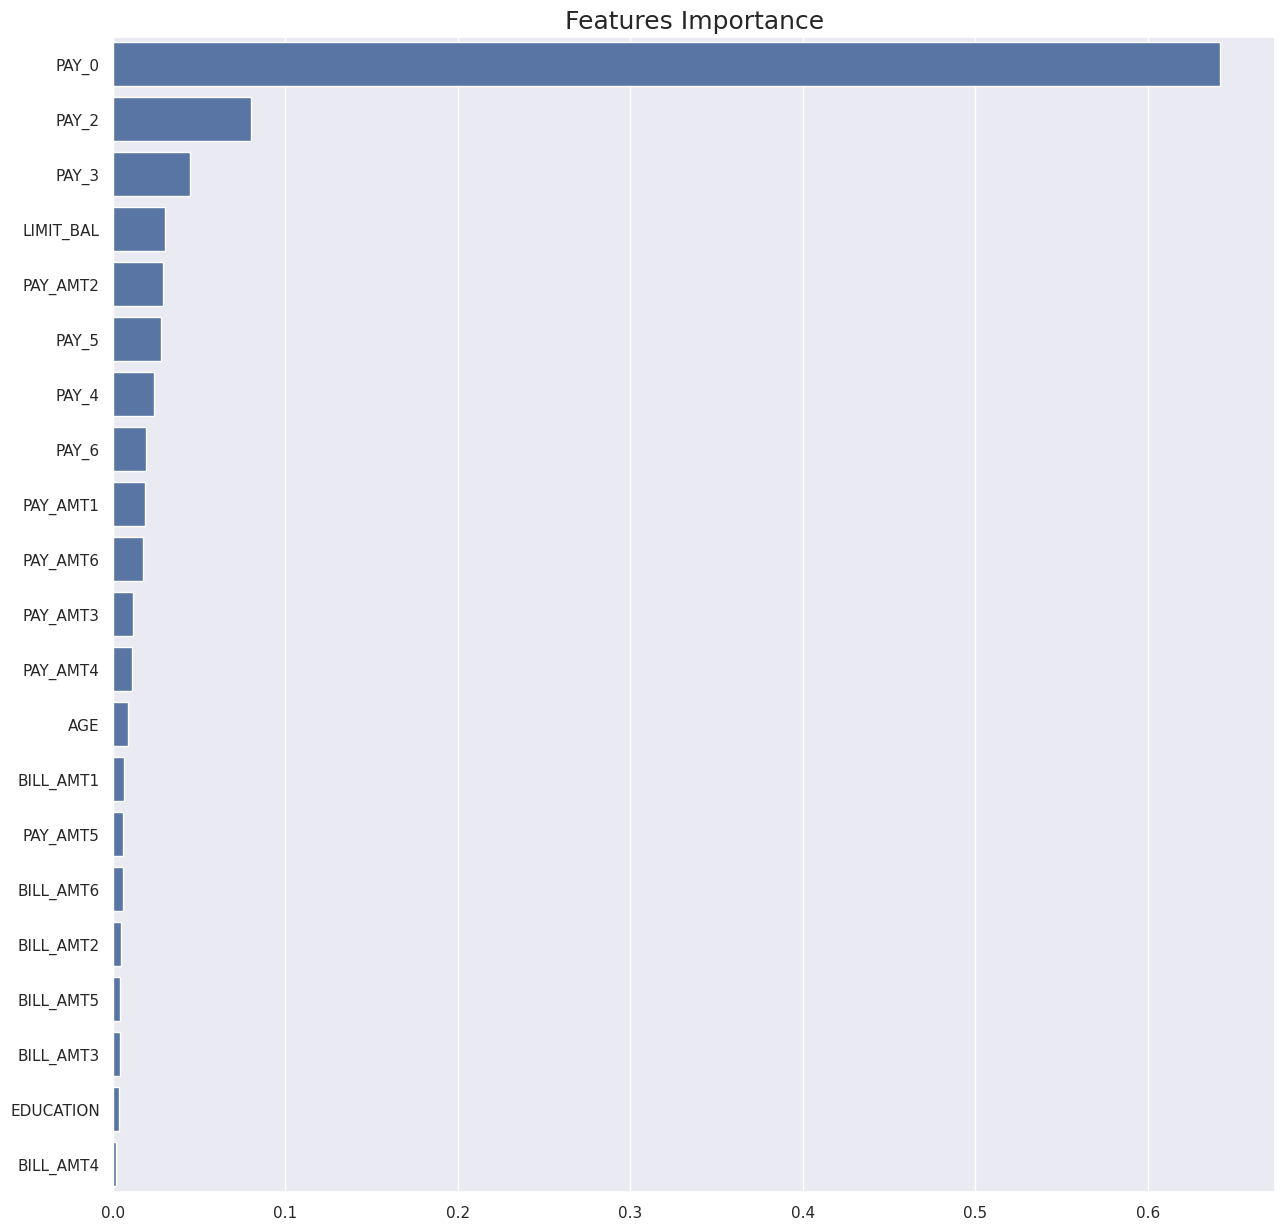

Time taken: 11.621801614761353 seconds


In [55]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def get_evaluation_scores(label, predictions):
    accuracy = accuracy_score(label, predictions)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(label, predictions))

def evaluate_result(df_train, df_test, features_name):
    start = time.time()

    x_train = df_train[features_name]
    y_train = df_train['label']

    x_test  = df_test[features_name]
    y_test  = df_test['label']

    model = GradientBoostingClassifier(n_estimators=250, random_state=0)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label=y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances = pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns = ['feature_name', 'feature_importance']
    feat_importances = feat_importances.sort_values(['feature_importance'], ascending=False)

    plt.figure(figsize=(15, 15))
    sns.barplot(x='feature_importance', y='feature_name', data=feat_importances)
    plt.title("Features Importance", size=18)
    plt.ylabel('', size=15)
    plt.xlabel('', size=15)
    plt.show()

    print(f"Time taken: {time.time() - start} seconds")

    return feat_importances, model, x_train, y_train, x_test, y_test

# Example usage
fet_importance_GBDT_reason, model, x_train, y_train, x_test, y_test = evaluate_result(df_train=train_woe,
                                                                                    df_test=test_woe,
                                                                                    features_name=features_use)

In [56]:
fet_importance_GBDT_reason

,feature_name,feature_importance
19,PAY_0,0.641879
14,PAY_2,0.080198
13,PAY_3,0.044386
17,LIMIT_BAL,0.030078
11,PAY_AMT2,0.028890
15,PAY_5,0.027666
12,PAY_4,0.023903
18,PAY_6,0.019000
6,PAY_AMT1,0.018523
9,PAY_AMT6,0.017613


In [57]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

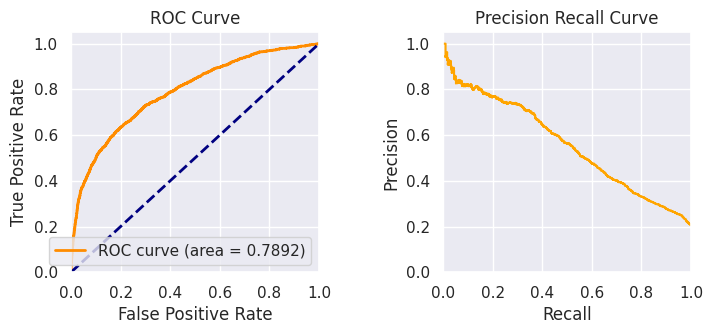

In [58]:
probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

Model Production

In [59]:
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['label']
x_test =test_woe[features_use]
y_test = test_woe['label']

In [60]:
#Train LR
#lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

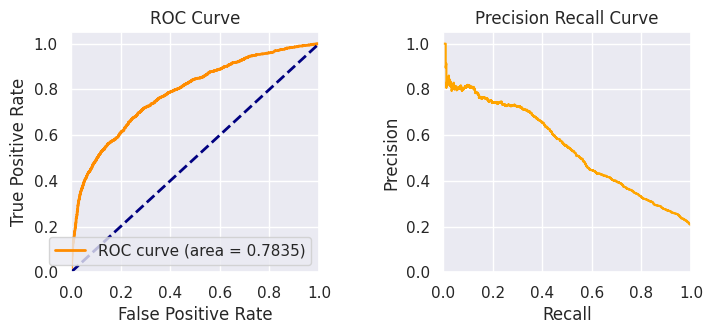

In [61]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

Scorecard generation


In [62]:
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x7aed860deaa0>, pdo=80,
          transer=<toad.transform.WOETransformer object at 0x7aed83f89240>)

In [63]:
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [64]:
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

In [65]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    30000.000000
mean       617.559238
std        118.265235
min        168.851703
25%        578.204047
50%        654.175758
75%        696.461008
max        818.460370
Name: CreditScore, dtype: float64

In [68]:
#output the scorecard
final_card_score=card.export()
len(final_card_score)

21

In [69]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=score_card_df.append(temp)
score_card_df.head(30)

<ipython-input-69-6648b97b2d83>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
<ipython-input-69-6648b97b2d83>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
<ipython-input-69-6648b97b2d83>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
<ipython-input-69-6648b97b2d83>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
<ipython-input-69-6648b97b2d83>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,variable,binning,score
0,EDUCATION,[-inf ~ 2),29.66
1,EDUCATION,[2 ~ inf),27.20
0,BILL_AMT4,[-inf ~ 2501),28.21
1,BILL_AMT4,[2501 ~ inf),27.97
0,BILL_AMT6,[-inf ~ 19195),27.33
1,BILL_AMT6,[19195 ~ 50442),31.37
2,BILL_AMT6,[50442 ~ inf),26.23
0,BILL_AMT5,[-inf ~ 2395),28.16
1,BILL_AMT5,[2395 ~ 8110),32.85
2,BILL_AMT5,[8110 ~ 35288),25.20


In [70]:
#save 6: save the scorcard
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

Distribution Analysis

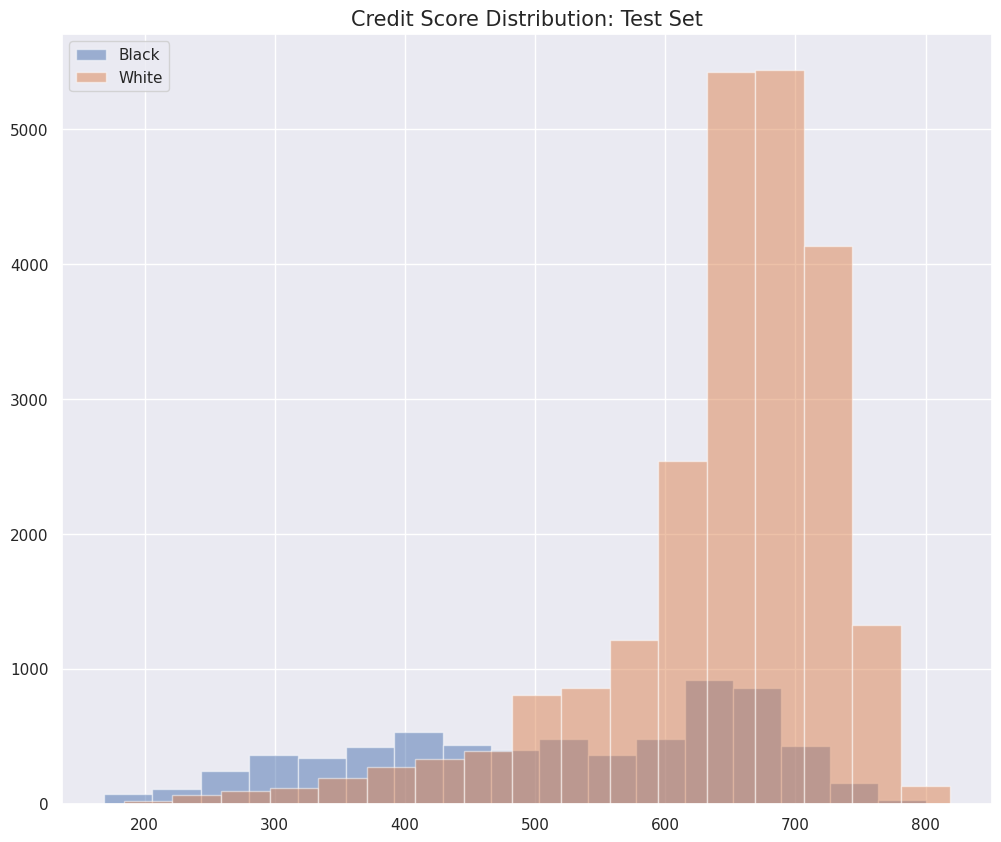

In [71]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((data['CreditScore'].max() - data['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(data[data.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(data[data.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

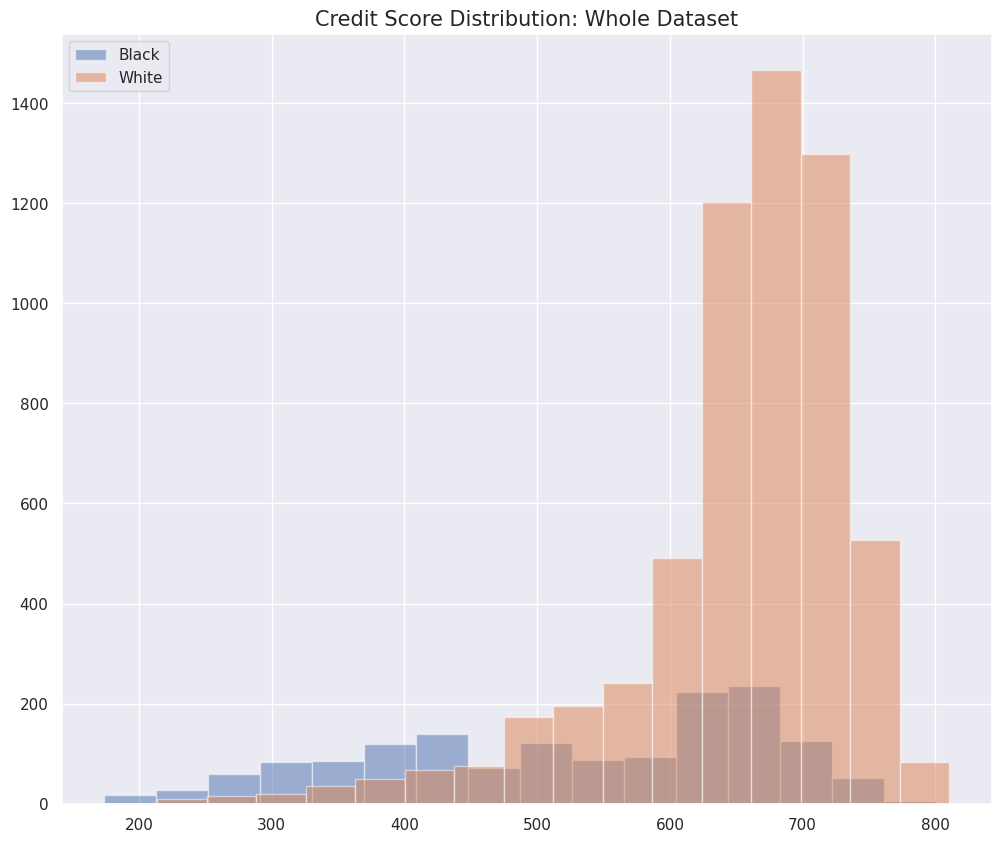

In [72]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

Threshold Tuning

In [73]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,
    level_2 = 250,
    level_3 = 300,
    level_4 = 350,
    level_5 = 400,
    level_6 = 450,
    level_7 = 500,
    level_8 = 800):
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)

    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.label==1].groupby(target_col)['label'].count()/ test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

In [74]:
test.CreditScore.describe()


count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

Threshold Tuning & Trade-off between loss & Coverage



In [75]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -1000,
    level_0 = 250,
    level_1 = 300,
    level_2 = 400,
    level_3 = 500,
    level_4 = 580,
    level_5 = 630,
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
                )

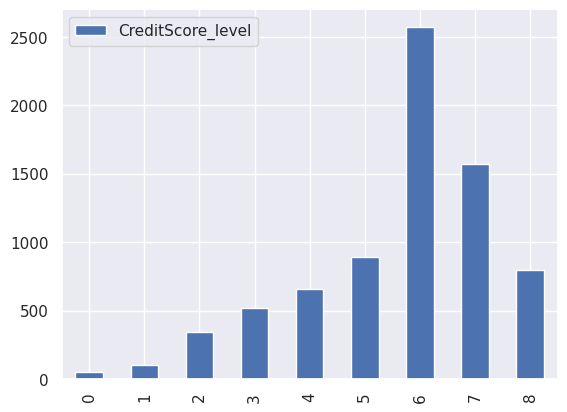

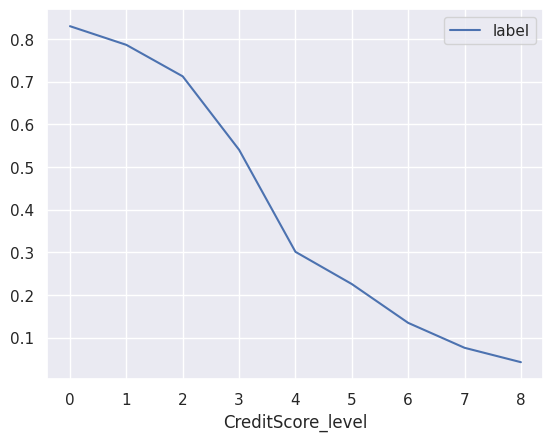

In [76]:
plot_bts_level_loss(test,target_col='CreditScore_level')


In [77]:
sum(test[test.label==1].CreditScore_level==7)

120

In [78]:

def get_loss_coverage(test,target_level):

    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].label.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)

    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].label.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)

    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)

     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)

    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].label.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)


    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].label.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)

    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].label.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)

    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].label.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)

    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].label.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [79]:
get_loss_coverage(test,target_level='CreditScore_level')


Level 8: Loss is  0.04271356783919598 ; Coverage is  0.12800268772047707
Level 7-Level 8: Loss is  0.0650887573964497 ; Coverage is  0.3715773559549807
Level 6-Level 8: Loss is  0.10143753796315043 ; Coverage is  0.745506467327398
Level 5-Level 8: Loss is  0.1204323211528564 ; Coverage is  0.8612464303712414
Level 4-Level 8: Loss is  0.13876040703052728 ; Coverage is  0.938350411557198
Level 3-Level 8: Loss is  0.1684751570531125 ; Coverage is  0.97833025365362
Level 2-Level 8: Loss is  0.19373723621511232 ; Coverage is  0.9947925415756761
Level 1-Level 8: Loss is  0.20193340494092374 ; Coverage is  0.9984881572316479
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [80]:
data.to_csv('OrderScore_save7_whole_data.csv',index=False)


In [81]:
test.loc[0,:]


ID                    22500.000000
LIMIT_BAL            420000.000000
SEX                       2.000000
EDUCATION                 2.000000
MARRIAGE                  1.000000
AGE                      37.000000
PAY_0                     0.000000
PAY_2                     0.000000
PAY_3                     0.000000
PAY_4                    -1.000000
PAY_5                     0.000000
PAY_6                     0.000000
BILL_AMT1             36032.000000
BILL_AMT2             41932.000000
BILL_AMT3              9778.000000
BILL_AMT4            158901.000000
BILL_AMT5            161876.000000
BILL_AMT6            165378.000000
PAY_AMT1               7022.000000
PAY_AMT2               1846.000000
PAY_AMT3             163862.000000
PAY_AMT4               6000.000000
PAY_AMT5               6000.000000
PAY_AMT6               6000.000000
label                     0.000000
CreditScore             751.330191
CreditScore_level         8.000000
Name: 0, dtype: float64

In [82]:
card.predict(test)[0]

751.3301912695952